Don't forget the quieter you become the more you are able to hear(RT) 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

genderclassmodel.csv
gendermodel.csv
gendermodel.py
myfirstforest.py
test.csv
train.csv



In this kernel i will try to compare performance of the random forest model on the Titanic train data set using only hyper parameter optimization.
Note that i will not use any complicated feature engineering only label encoder or dummies for categorical feature.

**I. What is Random Forest ?**

Random Forest is an ensemble tool which takes a subset of observations and a subset of variables to build a decision trees. It builds multiple such decision tree and amalgamate them together to get a more accurate and stable prediction. This is direct consequence of the fact that by maximum voting from a panel of independent judges, we get the final prediction better than the best judge. See Random Forest (Leo Brieman) https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

 **II. Random Forest Parameters** 

**n_estimators**  : integer, optional (default=10) The number of trees in the forest.

**criterion** : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

**max_features** : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split:
If int, then consider max_features features at each split.
If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
If “auto”, then max_features=sqrt(n_features).
If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.
Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

**max_depth** : integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split** : int, float, optional (default=2)
The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a percentage and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
Changed in version 0.18: Added float values for percentages.

**min_samples_leaf** : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node:
If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
Changed in version 0.18: Added float values for percentages.

**min_weight_fraction_leaf** : float, optional (default=0.)
The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
max_leaf_nodes : int or None, optional (default=None)
Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

**min_impurity_split** : float, optional (default=1e-7)
Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
New in version 0.18.

**bootstrap** : boolean, optional (default=True)
Whether bootstrap samples are used when building trees.

**oob_score**: bool (default=False)
Whether to use out-of-bag samples to estimate the generalization accuracy.

**n_jobs** : integer, optional (default=1)
The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.

**random_state** : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

**verbose** : int, optional (default=0)
Controls the verbosity of the tree building process.

**warm_start**: bool, optional (default=False)
When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.

**class_weight** : dict, list of dicts, “balanced”,

**III. Parameters to be tuned :**

In this notebook the parameters that will be tuned are : **max_features**, 
**n_estimators**, **max_depth**, **min_samples_split** and **criterion** 


**IV. Finally some Code** 

**IV.1. Load modules** 

In [2]:
#=====================================================================================================================
import pandas as pd                                       # data processing and CSV file I/O library
import numpy as np                                        # Algebra library
#import pandas_profiling as pdp                            # explore data 
#======================================================================================================================
from sklearn.ensemble.forest import RandomForestClassifier# to import the random forest Model 
from sklearn.metrics import roc_curve, auc                # to import roc curve abd auc metrics for evaluation 
from sklearn.grid_search import GridSearchCV              # grid search is used for hyperparameters-optimization
from sklearn.model_selection import KFold                # cross validation using the kfold algorithm
#from hyperopt import fmin, tpe, hp, STATUS_OK, Trials     # library for hyperparameters-optimization
#=======================================================================================================================
#  Plotting imports
import seaborn as sns                                     # Python graphing library
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


**IV.2. Function for model performance using AUC**

In [3]:
def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

**IV.3. Data**

In [4]:
frame= pd.read_csv("../input/train.csv")
frame.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data=frame.drop(['Name','Ticket','PassengerId'],axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [6]:
data=data.fillna(-9999,inplace=False)

In [7]:
BM=pd.get_dummies(data)

In [8]:
BM.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_-9999,Cabin_A10,...,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_-9999,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# split the farme data to train and validation datasets 70/30.
from sklearn.model_selection import train_test_split
train, valid = train_test_split(BM, test_size = 0.3,random_state=1991)

In [10]:
train.shape

(623, 160)

In [11]:
valid.shape

(268, 160)

In [12]:
train=pd.DataFrame(train,columns=BM.columns)
valid=pd.DataFrame(valid,columns=BM.columns)
X_train=train.drop(['Survived'],axis=1)
Y_train=train['Survived']
X_valid=valid.drop(['Survived'],axis=1)
Y_valid=valid['Survived']

In [13]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_-9999,Cabin_A10,Cabin_A14,...,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_-9999,Embarked_C,Embarked_Q,Embarked_S
826,3,-9999.0,0,0,56.4958,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
81,3,29.0,0,0,9.5000,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
80,3,22.0,0,0,9.0000,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
245,1,44.0,2,0,90.0000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
722,2,34.0,0,0,13.0000,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
X_valid.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_-9999,Cabin_A10,Cabin_A14,...,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_-9999,Embarked_C,Embarked_Q,Embarked_S
830,3,15.0,1,0,14.4542,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
812,2,35.0,0,0,10.5000,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
283,3,19.0,0,0,8.0500,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
490,3,-9999.0,1,0,19.9667,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
239,2,33.0,0,0,12.2750,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


**IV.4. Random forest without hyper parameter optimisation**

In [15]:
RF0=RandomForestClassifier()

In [16]:
RF0.fit(X=X_train,y=Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

the AUC is : 0.7883


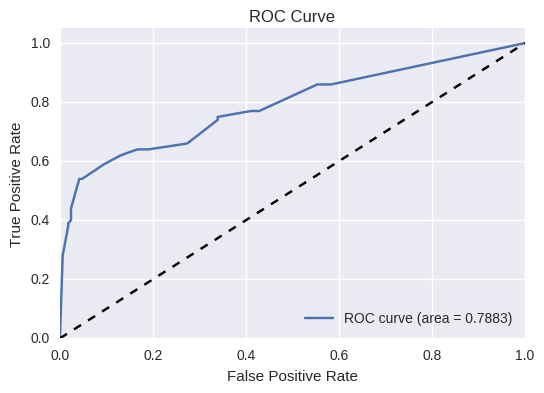

In [17]:
Performance(Model=RF0,Y=Y_valid,X=X_valid)

**IV.5. Random Forest using grid search**

In [18]:
grid_1 = { "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }

In [19]:
RF=RandomForestClassifier()
grid_search = GridSearchCV(RF, grid_1, n_jobs=-1, cv=5)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 6, 10], 'n_estimators': [100, 200, 500], 'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8], 'min_samples_split': [2, 5, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [20]:
grid_search.grid_scores_

[mean: 0.78652, std: 0.02455, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_split': 2},
 mean: 0.79133, std: 0.02867, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200, 'max_features': 'sqrt', 'min_samples_split': 2},
 mean: 0.78973, std: 0.01417, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_split': 2},
 mean: 0.78973, std: 0.02281, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_split': 5},
 mean: 0.78973, std: 0.02740, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200, 'max_features': 'sqrt', 'min_samples_split': 5},
 mean: 0.79615, std: 0.01736, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_split': 5},
 mean: 0.78812, std: 0.01300, params: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100, 'max_features': 'sqrt', 'mi

In [21]:
grid_search.best_score_

0.8443017656500803

In [22]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.5,
 'min_samples_split': 5,
 'n_estimators': 500}

the AUC is : 0.8138


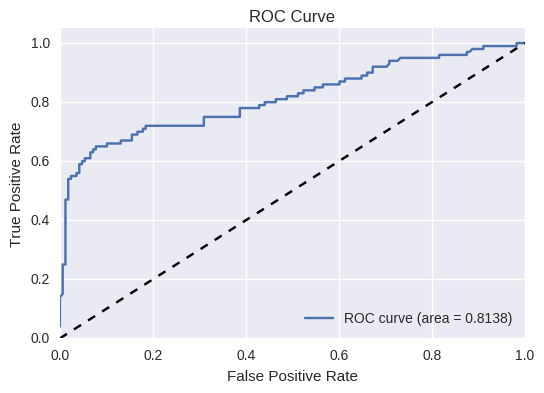

In [23]:
Performance(Model=grid_search,Y=Y_valid,X=X_valid)

**IV.6. Random Forest using hyperopt**

In [24]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [25]:
from sklearn.model_selection import cross_val_score
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, Y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,150)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best: 0.842646785582 {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 187, 'max_features': 49}
new best: 0.842646785582 {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 322, 'max_features': 99}
new best: 0.842646785582 {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 166, 'max_features': 8}
new best: 0.847454477889 {'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 145, 'max_features': 99}
new best: 0.847454477889 {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 394, 'max_features': 58}
new best: 0.847454477889 {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 424, 'max_features': 11}
new best: 0.847454477889 {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 211, 'max_features': 50}
new best: 0.847454477889 {'criterion': 'gini', 'max_depth': 19, 'n_estimators': 382, 'max_features': 51}
new best: 0.847454477889 {'criterion': 'gini', 'max_depth': 16, 'n_estimators': 171, 'max_features': 115}
new best: 0.847454477889 {'criterion': 'entropy', 

In [26]:
RF2=RandomForestClassifier(max_features=113, n_estimators=498, criterion= 'entropy', max_depth=2,random_state=1)

In [27]:
RF2.fit(X=X_train,y=Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features=113, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=498, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

the AUC is : 0.8411


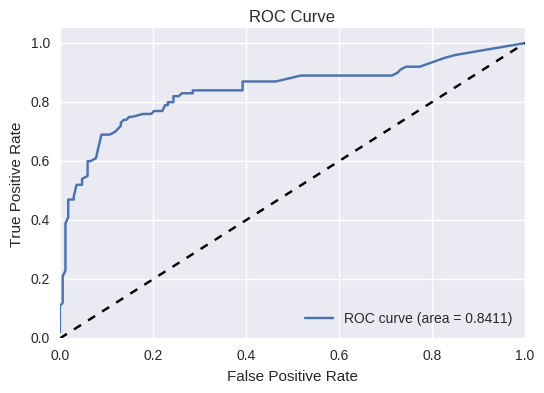

In [28]:
Performance(Model=RF2,Y=Y_valid,X=X_valid)

**References**

https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

http://scikit-learn.org/stable/modules/grid_search.html

http://stackoverflow.com/questions/19335165/cross-validation-and-grid-search